# Statistical values for ESHG abstract: 100% of the found uncoupled genes are LOEUF-essentia

In [12]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from scipy import stats
import pandas as pd

from rich.table import Table
from rich.console import Console
from rich.panel import Panel

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150

def _resolve_project_root() -> Path:
    here = Path.cwd().resolve()
    for candidate in (here, *here.parents):
        if (candidate / 'config.py').exists():
            return candidate
    raise FileNotFoundError('config.py not found in cwd or parents')

PROJECT_ROOT = _resolve_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print(f'project root: {PROJECT_ROOT}')

from config import (
    GENE_PATHS,
    VARIANT_PATHS,
    SOURCE_PALETTE,
    load_variant_pairs_matched,
)
from utils.plot_utils import autosave

print('\navailable datasets:')
for name in ['clingen', 'clingen_null', 'background', 'background_null']:
    print(f'  {name}: {VARIANT_PATHS[name].name}')

project root: /Users/markus/in-silico-vg-analysis

available datasets:
  clingen: ClinGen_HI_Gnomad_variants_dedup_27012026.parquet
  clingen_null: ClinGen_HI_Synth_variants_downsampled_perm_27012026.parquet
  background: Background_Gnomad_variants_dedup_perm_27012026.parquet
  background_null: Background_Synth_variants_downsampled_perm_27012026.parquet


In [13]:
CLINGEN_VAR = VARIANT_PATHS['clingen']
BG_VAR = VARIANT_PATHS['background']
BG_NULL_VAR = VARIANT_PATHS['background_null']
CLINGEN_NULL_VAR = VARIANT_PATHS['clingen_null']

CLINGEN_GENE = GENE_PATHS['clingen']
BG_GENE = GENE_PATHS['background']
BG_NULL_GENE = GENE_PATHS['background_null']
CLINGEN_NULL_GENE = GENE_PATHS['clingen_null']

PATHS = {
    'background': BG_VAR,
    'background_null': BG_NULL_VAR,
    'clingen': CLINGEN_VAR,
    'clingen_null': CLINGEN_NULL_VAR,
}

df = pl.read_parquet(BG_VAR)
print(df.columns)

['variant_id', 'scored_interval', 'gene_id', 'gene_name', 'gene_type', 'gene_strand', 'junction_Start', 'junction_End', 'output_type', 'variant_scorer', 'track_name', 'track_strand', 'Assay title', 'ontology_curie', 'biosample_name', 'biosample_type', 'gtex_tissue', 'raw_score', 'quantile_score', 'scored_interval_str', 'is_anchor', 'seq_len', 'scorer_friendly', 'gene_norm', 'CHROM', 'POS', 'REF', 'ALT', 'gene_tag', 'method_friendly', 'variant_id_canonical', 'CHROM_af', 'POS_af', 'REF_af', 'ALT_af', 'AF', 'perm_AF']


## Load Data

load variant and gene-level data using convenience functions

### Variant level

In [14]:
real_bg = pl.read_parquet(VARIANT_PATHS['background'])
null_bg = pl.read_parquet(VARIANT_PATHS['background_null'])
real_cg = pl.read_parquet(VARIANT_PATHS['clingen'])
null_cg = pl.read_parquet(VARIANT_PATHS['clingen_null'])

variant_tables = {
    'background': real_bg,
    'background_null': null_bg,
    'clingen': real_cg,
    'clingen_null': null_cg,
}

print("Loading and aligning gene metadata...")
gene_tables = {
    'background': pl.read_parquet(GENE_PATHS['background']),
    'background_null': pl.read_parquet(GENE_PATHS['background_null']),
    'clingen': pl.read_parquet(GENE_PATHS['clingen']),
    'clingen_null': pl.read_parquet(GENE_PATHS['clingen_null']),
}

for name in gene_tables:
    valid_genes = variant_tables[name]['gene_id'].unique().to_list()

    gene_tables[name] = gene_tables[name].filter(pl.col('gene_id').is_in(valid_genes))

    print(f"  {name}: aligned to {gene_tables[name].height} genes")

Loading and aligning gene metadata...
  background: aligned to 349 genes
  background_null: aligned to 349 genes
  clingen: aligned to 316 genes
  clingen_null: aligned to 316 genes


In [15]:
# aggregate variant-level data to gene-level
# this creates the plot_data dictionary needed for downstream analysis

def compute_gene_vg(variant_df: pl.DataFrame, af_col: str, out_col: str) -> pl.DataFrame:
    """computes variant-level vg contribution and sums it per gene"""
    # calculate 2pq * beta^2 and sum per gene
    return (
        variant_df.with_columns(
            (2.0 * pl.col(af_col) * (1.0 - pl.col(af_col)) * pl.col("raw_score").pow(2))
            .alias("vg_contribution")
        )
        .group_by("gene_id")
        .agg(pl.col("vg_contribution").sum().alias(out_col))
    )

plot_data = {}
datasets = ['clingen', 'background']

print('aggregating variants to gene level...')
for name in datasets:
    # compute observed vg
    real_df = variant_tables[name]
    vg_obs = compute_gene_vg(real_df, "AF", "vg_predicted")
    
    # compute simulated vg using permuted allele frequencies
    null_df = variant_tables[f"{name}_null"]
    vg_sim = compute_gene_vg(null_df, "perm_AF", "vg_predicted_perm")
    
    # merge observed and simulated
    merged_vg = vg_obs.join(vg_sim, on="gene_id", how="inner")
    
    # get eqtl variance and null confidence intervals from gene metadata
    # check which columns are available in this gene table
    available_cols = ['gene_id', 'vg_eqtl']
    if 'vg_perm_p05' in gene_tables[name].columns:
        available_cols.extend(['vg_perm_p05', 'vg_perm_p95'])
    gene_metadata = gene_tables[name].select(available_cols)
    
    # join everything
    final_df = merged_vg.join(
        gene_metadata, on="gene_id", how="left"
    ).filter(
        (pl.col("vg_predicted") > 0) & 
        (pl.col("vg_predicted_perm") > 0) &
        (pl.col("vg_eqtl").is_not_null())
    ).to_pandas()
    
    final_df["log_prior_vg"] = np.log10(final_df["vg_eqtl"] + 1e-9)
    
    plot_data[name] = final_df
    print(f"  {name}: {len(final_df)} genes aggregated")

print(f'\nplot_data created with {len(plot_data)} datasets')

aggregating variants to gene level...
  clingen: 315 genes aggregated
  background: 329 genes aggregated

plot_data created with 2 datasets


## Correlation Analysis: Independence

To validate that the constraint score captures genuine biological signal rather than artifacts,
we test whether it correlates with simple frequency metrics:
- **Total number of variants per gene** (sampling depth artifact)
- **Mean allele frequency** (common vs rare variant bias)

If correlations are near zero, this confirms the score is independent of these confounders.

In [16]:
datasets = {
    'background': {
        'variants': variant_tables['background'],
        'genes': plot_data['background'].copy(),
        'color': SOURCE_PALETTE['background'],
        'label': 'Background Genes'
    },
    'clingen': {
        'variants': variant_tables['clingen'],
        'genes': plot_data['clingen'].copy(),
        'color': SOURCE_PALETTE['clingen'],
        'label': 'ClinGen Haploinsufficient'
    }
}

correlation_results = {}

for dataset_name, data in datasets.items():
    print(f'correlation analysis: {data["label"]}')
    
    variants = data['variants']
    gene_stats = variants.group_by('gene_id').agg([
        pl.count('variant_id').alias('n_variants'),
        pl.mean('AF').alias('mean_af'),
        pl.median('AF').alias('median_af')
    ]).to_pandas()
    
    genes_df = data['genes']
    genes_df['constraint_score'] = np.log10(
        genes_df['vg_predicted'] / genes_df['vg_predicted_perm']
    )
    
    merged = genes_df.merge(gene_stats, on='gene_id', how='inner')
    
    valid = merged.dropna(subset=['constraint_score', 'n_variants', 'mean_af'])
    
    corr_n = stats.spearmanr(valid['constraint_score'], valid['n_variants'])
    corr_af = stats.spearmanr(valid['constraint_score'], valid['mean_af'])
    
    correlation_results[dataset_name] = {
        'data': valid,
        'corr_n_variants': corr_n,
        'corr_mean_af': corr_af
    }
    
    print(f'n genes analyzed: {len(valid):,}')
    print()
    print(f'constraint score vs total variants per gene:')
    print(f'  spearman rho = {corr_n.statistic:.4f}')
    print(f'  p-value = {corr_n.pvalue:.2e}')
    print()
    print(f'constraint score vs mean allele frequency:')
    print(f'  spearman rho = {corr_af.statistic:.4f}')
    print(f'  p-value = {corr_af.pvalue:.2e}')
    print()

for dataset_name in ['background', 'clingen']:
    res = correlation_results[dataset_name]
    label = datasets[dataset_name]['label']
    print(f'\n{label}:')
    print(f'  n_variants: rho = {res["corr_n_variants"].statistic:+.3f}')
    print(f'  mean_af:    rho = {res["corr_mean_af"].statistic:+.3f}')
print('\n' + '='*70)

correlation analysis: Background Genes
n genes analyzed: 329

constraint score vs total variants per gene:
  spearman rho = 0.0863
  p-value = 1.18e-01

constraint score vs mean allele frequency:
  spearman rho = 0.0607
  p-value = 2.72e-01

correlation analysis: ClinGen Haploinsufficient
n genes analyzed: 315

constraint score vs total variants per gene:
  spearman rho = 0.1380
  p-value = 1.42e-02

constraint score vs mean allele frequency:
  spearman rho = 0.0148
  p-value = 7.94e-01


Background Genes:
  n_variants: rho = +0.086
  mean_af:    rho = +0.061

ClinGen Haploinsufficient:
  n_variants: rho = +0.138
  mean_af:    rho = +0.015



/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_46450/230079431.py:89: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.985])
/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_46450/230079431.py:89: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.985])
/Users/markus/in-silico-vg-analysis/utils/plot_utils.py:119: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.savefig(fname, format=fmt, **save_kwargs)
/Users/markus/in-silico-vg-analysis/utils/plot_utils.py:119: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.savefig(fname, format=fmt, **save_kwargs)


[save_plot] Saved: interactive_Constraint_Score_Independence_Both_Datasets_28012026_1614.pdf
[save_plot] Saved: interactive_Constraint_Score_Independence_Both_Datasets_28012026_1614.svg


/Users/markus/in-silico-vg-analysis/.venv/lib/python3.14/site-packages/IPython/core/events.py:96: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/markus/in-silico-vg-analysis/.venv/lib/python3.14/site-packages/IPython/core/events.py:96: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/markus/in-silico-vg-analysis/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/markus/in-silico-vg-analysis/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


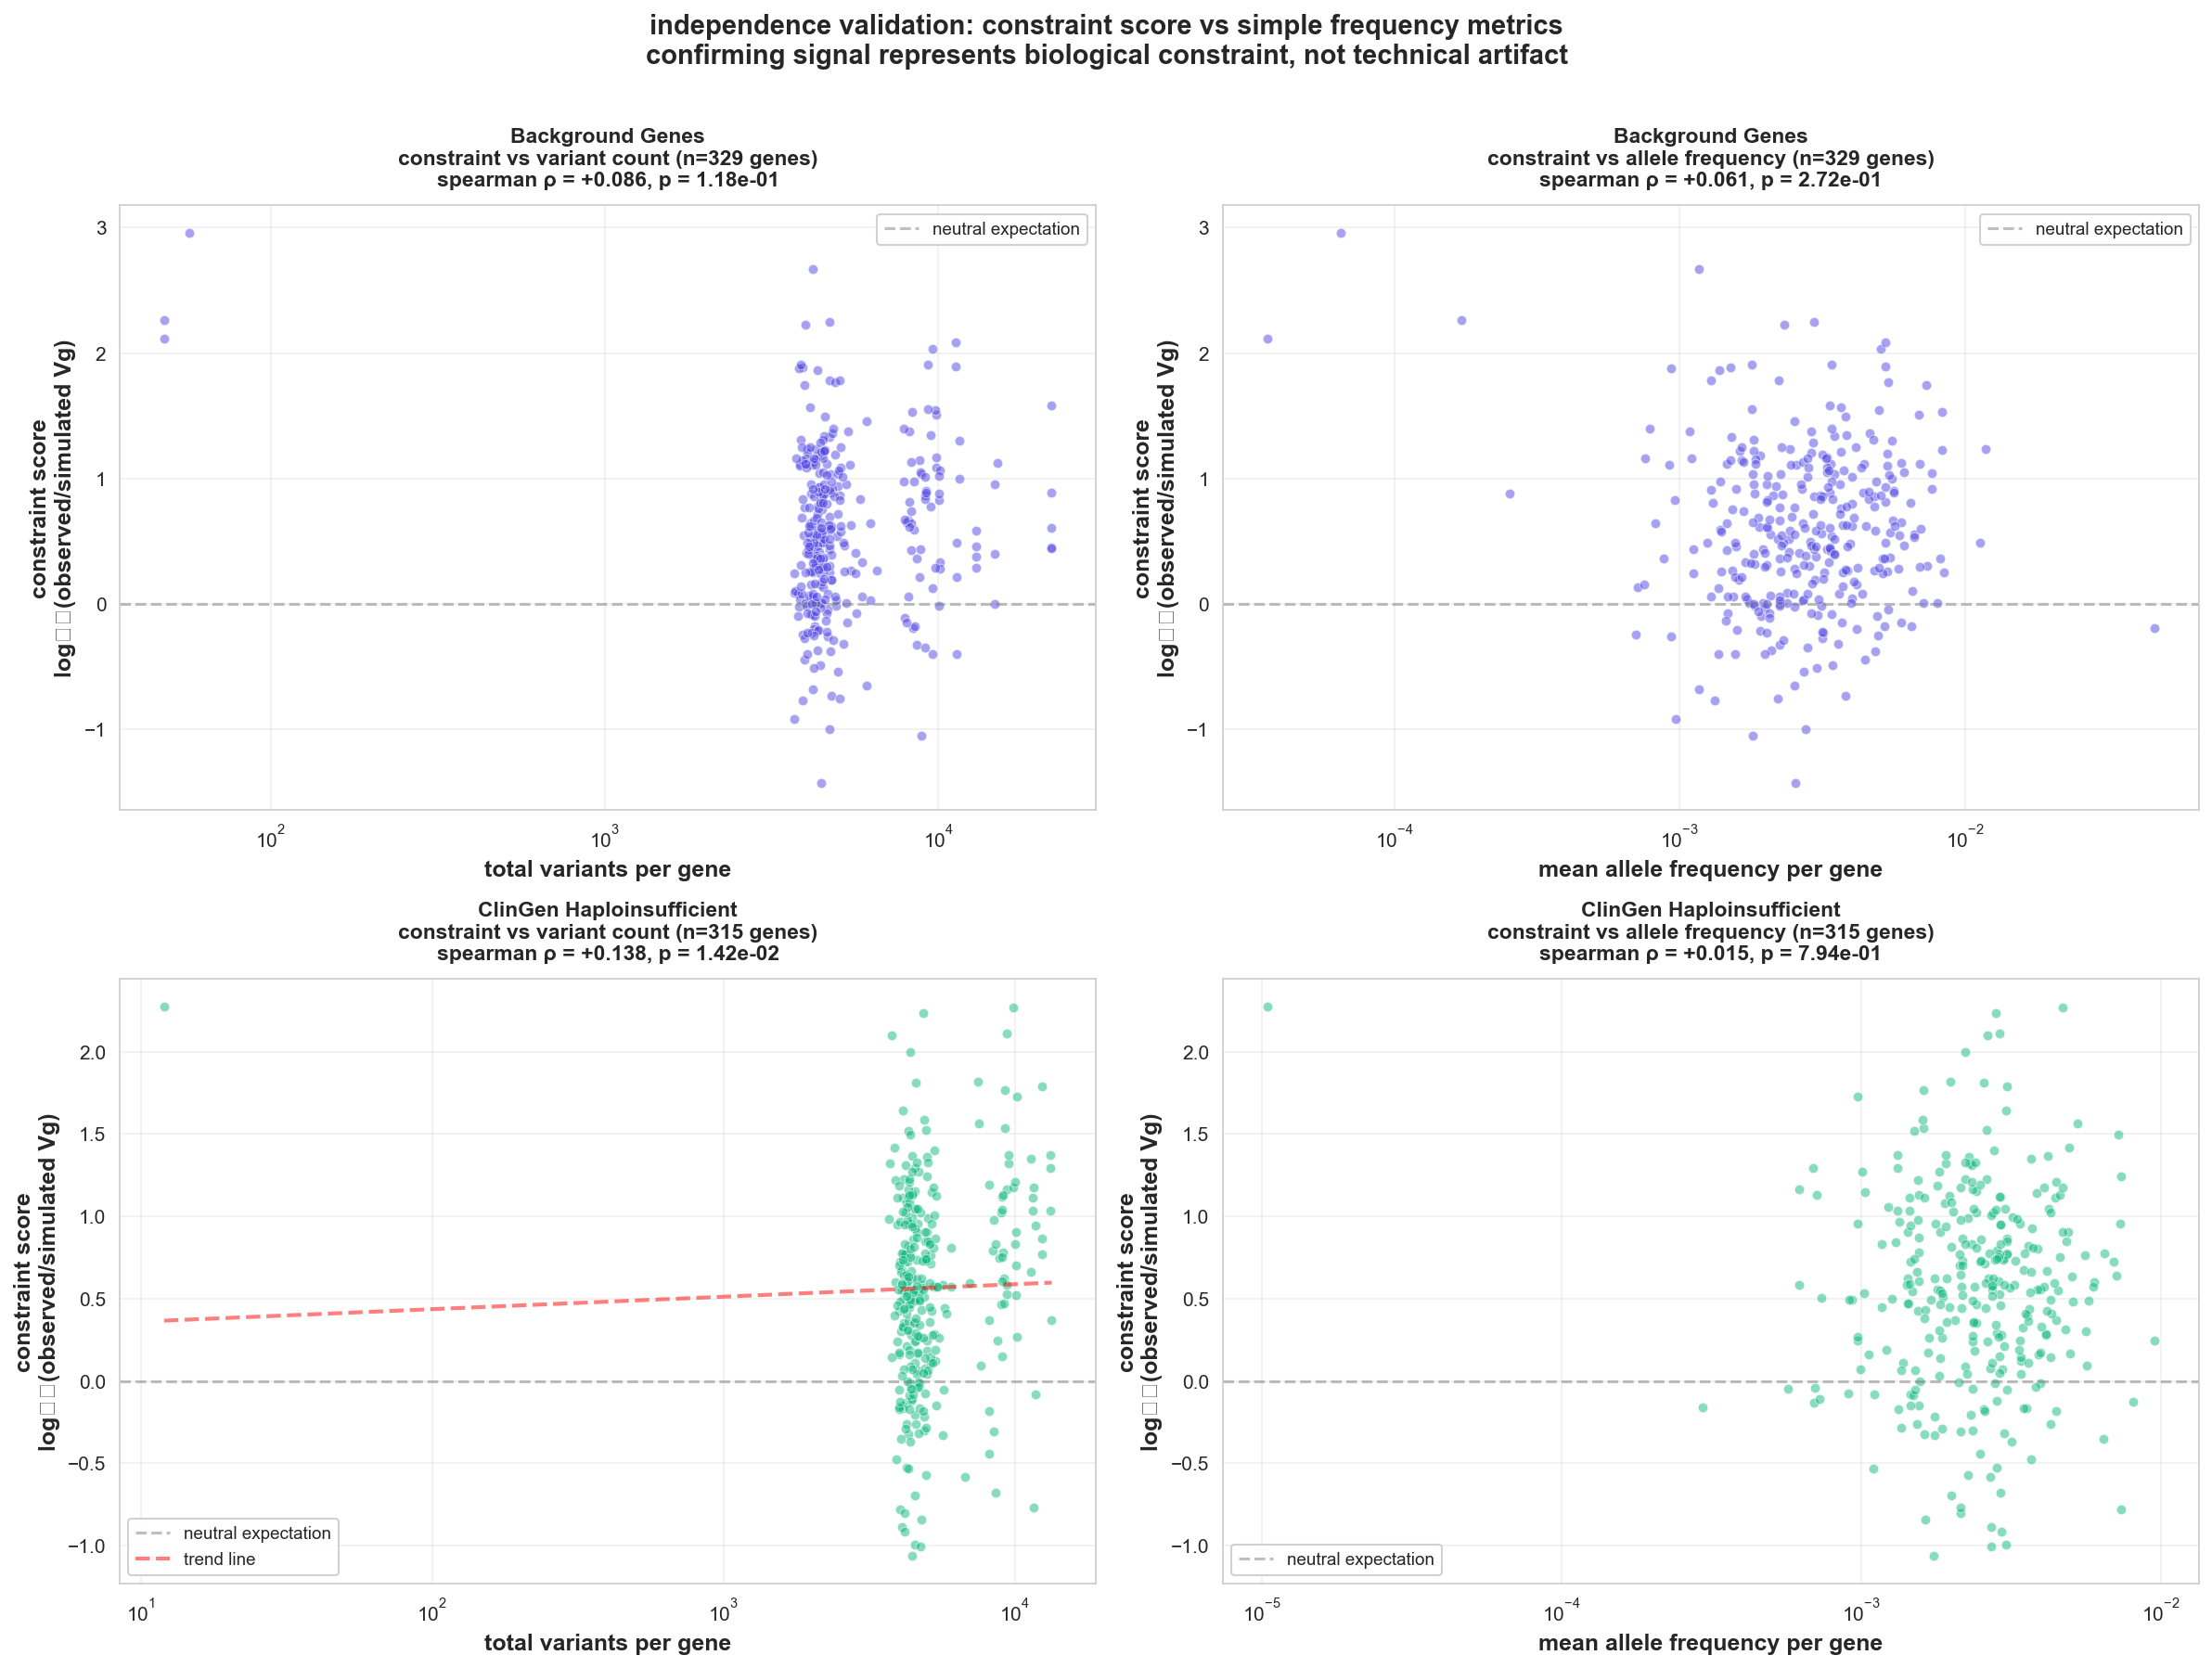

In [17]:
with autosave('Constraint_Score_Independence_Both_Datasets', verbose=True):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    for row_idx, dataset_name in enumerate(['background', 'clingen']):
        data_info = datasets[dataset_name]
        res = correlation_results[dataset_name]
        valid = res['data']
        color = data_info['color']
        
        # panel 1: constraint score vs number of variants
        ax = axes[row_idx, 0]
        ax.scatter(
            valid['n_variants'], 
            valid['constraint_score'],
            alpha=0.5, 
            s=25, 
            color=color, 
            edgecolors='white', 
            linewidth=0.5
        )
        ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5, label='neutral expectation')
        
        # add correlation line if significant
        if abs(res['corr_n_variants'].statistic) > 0.1:
            z = np.polyfit(np.log10(valid['n_variants']), valid['constraint_score'], 1)
            p = np.poly1d(z)
            x_line = np.logspace(
                np.log10(valid['n_variants'].min()), 
                np.log10(valid['n_variants'].max()), 
                100
            )
            ax.plot(x_line, p(np.log10(x_line)), 'r--', alpha=0.5, linewidth=2, label='trend line')
        
        ax.set_xlabel('total variants per gene', fontsize=12, fontweight='bold')
        ax.set_ylabel('constraint score\nlog₁₀(observed/simulated Vg)', fontsize=12, fontweight='bold')
        ax.set_title(
            f'{data_info["label"]}\n'
            f'constraint vs variant count (n={len(valid):,} genes)\n'
            f'spearman ρ = {res["corr_n_variants"].statistic:+.3f}, '
            f'p = {res["corr_n_variants"].pvalue:.2e}',
            fontsize=11, fontweight='bold', pad=10
        )
        ax.set_xscale('log')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', framealpha=0.9, fontsize=9)
        
        # panel 2: constraint score vs mean af
        ax = axes[row_idx, 1]
        ax.scatter(
            valid['mean_af'], 
            valid['constraint_score'],
            alpha=0.5, 
            s=25, 
            color=color, 
            edgecolors='white', 
            linewidth=0.5
        )
        ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5, label='neutral expectation')
        
        # add correlation line if significant
        if abs(res['corr_mean_af'].statistic) > 0.1:
            z = np.polyfit(np.log10(valid['mean_af']), valid['constraint_score'], 1)
            p = np.poly1d(z)
            x_line = np.logspace(
                np.log10(valid['mean_af'].min()), 
                np.log10(valid['mean_af'].max()), 
                100
            )
            ax.plot(x_line, p(np.log10(x_line)), 'r--', alpha=0.5, linewidth=2, label='trend line')
        
        ax.set_xlabel('mean allele frequency per gene', fontsize=12, fontweight='bold')
        ax.set_ylabel('constraint score\nlog₁₀(observed/simulated Vg)', fontsize=12, fontweight='bold')
        ax.set_title(
            f'{data_info["label"]}\n'
            f'constraint vs allele frequency (n={len(valid):,} genes)\n'
            f'spearman ρ = {res["corr_mean_af"].statistic:+.3f}, '
            f'p = {res["corr_mean_af"].pvalue:.2e}',
            fontsize=11, fontweight='bold', pad=10
        )
        ax.set_xscale('log')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', framealpha=0.9, fontsize=9)
    
    plt.suptitle(
        'independence validation: constraint score vs simple frequency metrics\n'
        'confirming signal represents biological constraint, not technical artifact',
        fontsize=14, fontweight='bold', y=0.995
    )
    plt.tight_layout(rect=[0, 0, 1, 0.985])

# LOEUF scores

In [18]:

for dataset_name in ['background', 'clingen']:
    # get loeuf from gene tables if available
    if 'loeuf_score' in gene_tables[dataset_name].columns:
        loeuf_data = gene_tables[dataset_name].select(['gene_id', 'loeuf_score']).to_pandas()
        plot_data[dataset_name] = plot_data[dataset_name].merge(
            loeuf_data, on='gene_id', how='left'
        )
        n_with_loeuf = plot_data[dataset_name]['loeuf_score'].notna().sum()
        print(f'  {dataset_name}: {n_with_loeuf}/{len(plot_data[dataset_name])} genes with loeuf')
    else:
        print(f'  {dataset_name}: loeuf not available')

LOEUF_ESSENTIAL = 0.35  # known essential genes (highly intolerant)
LOEUF_TOLERANT = 1.0    # neutral/tolerant genes

print(f'\nstandard thresholds:')
print(f'  essential genes: loeuf < {LOEUF_ESSENTIAL}')
print(f'  tolerant genes:  loeuf > {LOEUF_TOLERANT}')

  background: 251/329 genes with loeuf
  clingen: 260/315 genes with loeuf

standard thresholds:
  essential genes: loeuf < 0.35
  tolerant genes:  loeuf > 1.0


# Calculate Constraint Scores and Classifications

In [19]:
bg_df = plot_data['background'].copy()
bg_df['constraint_score'] = np.log10(bg_df['vg_predicted'] / bg_df['vg_predicted_perm'])
bg_df['log_sim'] = np.log10(bg_df['vg_predicted_perm'])

THRESHOLDS = {
    'constraint_score': -0.30,
    'veqtl_high': 0.50
}

# classify genes
bg_df['in_zone'] = bg_df['constraint_score'] < THRESHOLDS['constraint_score']
bg_df['is_uncoupled'] = bg_df['in_zone'] & (bg_df['vg_eqtl'] > THRESHOLDS['veqtl_high'])
bg_df['is_coupled'] = bg_df['in_zone'] & (bg_df['vg_eqtl'] <= THRESHOLDS['veqtl_high'])

# classify by loeuf
bg_df['loeuf_class'] = 'unknown'
bg_df.loc[bg_df['loeuf_score'] < LOEUF_ESSENTIAL, 'loeuf_class'] = 'essential'
bg_df.loc[bg_df['loeuf_score'] > LOEUF_TOLERANT, 'loeuf_class'] = 'tolerant'
bg_df.loc[
    (bg_df['loeuf_score'] >= LOEUF_ESSENTIAL) & 
    (bg_df['loeuf_score'] <= LOEUF_TOLERANT), 
    'loeuf_class'
] = 'intermediate'

# filter to genes with loeuf data
bg_with_loeuf = bg_df[bg_df['loeuf_score'].notna()].copy()

print(f'analysis dataset: {len(bg_with_loeuf):,} background genes with loeuf scores')
print(f'\nloeuf classification:')
for cls in ['essential', 'intermediate', 'tolerant']:
    n = (bg_with_loeuf['loeuf_class'] == cls).sum()
    pct = 100 * n / len(bg_with_loeuf)
    print(f'  {cls:12s}: {n:4d} ({pct:5.1f}%)')

print(f'\nconstraint classification:')
print(f'  uncoupled:   {bg_with_loeuf["is_uncoupled"].sum():4d} ({100*bg_with_loeuf["is_uncoupled"].mean():.1f}%)')
print(f'  coupled:     {bg_with_loeuf["is_coupled"].sum():4d} ({100*bg_with_loeuf["is_coupled"].mean():.1f}%)')
print(f'  neutral:     {(~bg_with_loeuf["in_zone"]).sum():4d} ({100*(~bg_with_loeuf["in_zone"]).mean():.1f}%)')

analysis dataset: 251 background genes with loeuf scores

loeuf classification:
  essential   :  188 ( 74.9%)
  intermediate:   35 ( 13.9%)
  tolerant    :   28 ( 11.2%)

constraint classification:
  uncoupled:      2 (0.8%)
  coupled:       13 (5.2%)
  neutral:      236 (94.0%)


# Statistical Comparison: constraint score standard loeuf classes'

In [20]:
# statistical comparison: constraint scores by loeuf class


loeuf_groups = {
    'essential': bg_with_loeuf[bg_with_loeuf['loeuf_class'] == 'essential'],
    'intermediate': bg_with_loeuf[bg_with_loeuf['loeuf_class'] == 'intermediate'],
    'tolerant': bg_with_loeuf[bg_with_loeuf['loeuf_class'] == 'tolerant']
}

# compute statistics for each group
for group_name, group_df in loeuf_groups.items():
    if len(group_df) == 0:
        continue
    
    scores = group_df['constraint_score'].dropna()
    print(f'\n{group_name} genes (loeuf {"<" if group_name == "essential" else ">" if group_name == "tolerant" else "~"} {LOEUF_ESSENTIAL if group_name == "essential" else LOEUF_TOLERANT}):')
    print(f'  n = {len(scores):,}')
    print(f'  mean constraint score = {scores.mean():.3f}')
    print(f'  median constraint score = {scores.median():.3f}')
    print(f'  % constrained (score < -0.3) = {100 * (scores < -0.3).mean():.1f}%')

# test if essential genes have lower constraint scores
if len(loeuf_groups['essential']) > 0 and len(loeuf_groups['tolerant']) > 0:
    essential_scores = loeuf_groups['essential']['constraint_score'].dropna()
    tolerant_scores = loeuf_groups['tolerant']['constraint_score'].dropna()
    
    u_stat, p_val = stats.mannwhitneyu(essential_scores, tolerant_scores, alternative='less')
    
    print(f'\n{"="*70}')
    print(f'mann-whitney u test: essential vs tolerant')
    print(f'  h0: essential genes have same/higher constraint scores than tolerant')
    print(f'  ha: essential genes have lower constraint scores (more constrained)')
    print(f'  u-statistic = {u_stat:,.0f}')
    print(f'  p-value = {p_val:.2e}')
    if p_val < 0.001:
        print(f'  ★★★ highly significant: constraint score validates against loeuf')
    elif p_val < 0.05:
        print(f'  ★ significant: constraint score correlates with essentiality')
    else:
        print(f'  not significant')
    print(f'{"="*70}')


essential genes (loeuf < 0.35):
  n = 188
  mean constraint score = 0.592
  median constraint score = 0.582
  % constrained (score < -0.3) = 6.9%

intermediate genes (loeuf ~ 1.0):
  n = 35
  mean constraint score = 0.735
  median constraint score = 0.612
  % constrained (score < -0.3) = 0.0%

tolerant genes (loeuf > 1.0):
  n = 28
  mean constraint score = 0.467
  median constraint score = 0.491
  % constrained (score < -0.3) = 7.1%

mann-whitney u test: essential vs tolerant
  h0: essential genes have same/higher constraint scores than tolerant
  ha: essential genes have lower constraint scores (more constrained)
  u-statistic = 2,951
  p-value = 8.50e-01
  not significant


# Enrichment Analysis for Uncoupled Genes

In [21]:
# enrichment analysis: are uncoupled genes enriched for low loeuf?
# calculate loeuf distributions
uncoupled = bg_with_loeuf[bg_with_loeuf['is_uncoupled']]
neutral = bg_with_loeuf[~bg_with_loeuf['in_zone']]

print(f'\nuncoupled genes (n={len(uncoupled)}):')
if len(uncoupled) > 0:
    print(f'  mean loeuf = {uncoupled["loeuf_score"].mean():.3f}')
    print(f'  median loeuf = {uncoupled["loeuf_score"].median():.3f}')
    print(f'  % essential (loeuf < {LOEUF_ESSENTIAL}) = {100 * (uncoupled["loeuf_score"] < LOEUF_ESSENTIAL).mean():.1f}%')
else:
    print('  no uncoupled genes found')

print(f'\nneutral background (n={len(neutral)}):')
print(f'  mean loeuf = {neutral["loeuf_score"].mean():.3f}')
print(f'  median loeuf = {neutral["loeuf_score"].median():.3f}')
print(f'  % essential (loeuf < {LOEUF_ESSENTIAL}) = {100 * (neutral["loeuf_score"] < LOEUF_ESSENTIAL).mean():.1f}%')

# statistical test
if len(uncoupled) > 0:
    u_stat, p_val = stats.mannwhitneyu(
        uncoupled['loeuf_score'].dropna(), 
        neutral['loeuf_score'].dropna(),
        alternative='less'
    )
    
    print(f'\nmann-whitney u test:')
    print(f'  u-statistic = {u_stat:,.0f}')
    print(f'  p-value = {p_val:.2e}')
    
    if p_val < 0.05:
        print(f'  ★ uncoupled genes are enriched for low loeuf (essential-like)')
    else:
        print(f'  no significant enrichment')



uncoupled genes (n=2):
  mean loeuf = -0.450
  median loeuf = -0.450
  % essential (loeuf < 0.35) = 100.0%

neutral background (n=236):
  mean loeuf = 0.056
  median loeuf = -0.114
  % essential (loeuf < 0.35) = 74.2%

mann-whitney u test:
  u-statistic = 156
  p-value = 2.21e-01
  no significant enrichment


/Users/markus/in-silico-vg-analysis/utils/plot_utils.py:119: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.savefig(fname, format=fmt, **save_kwargs)
/Users/markus/in-silico-vg-analysis/utils/plot_utils.py:119: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.savefig(fname, format=fmt, **save_kwargs)


[save_plot] Saved: interactive_Standard_Benchmarking_LOEUF_28012026_1614.pdf
[save_plot] Saved: interactive_Standard_Benchmarking_LOEUF_28012026_1614.svg


/Users/markus/in-silico-vg-analysis/.venv/lib/python3.14/site-packages/IPython/core/events.py:96: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/markus/in-silico-vg-analysis/.venv/lib/python3.14/site-packages/IPython/core/events.py:96: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  func(*args, **kwargs)
/Users/markus/in-silico-vg-analysis/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/markus/in-silico-vg-analysis/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


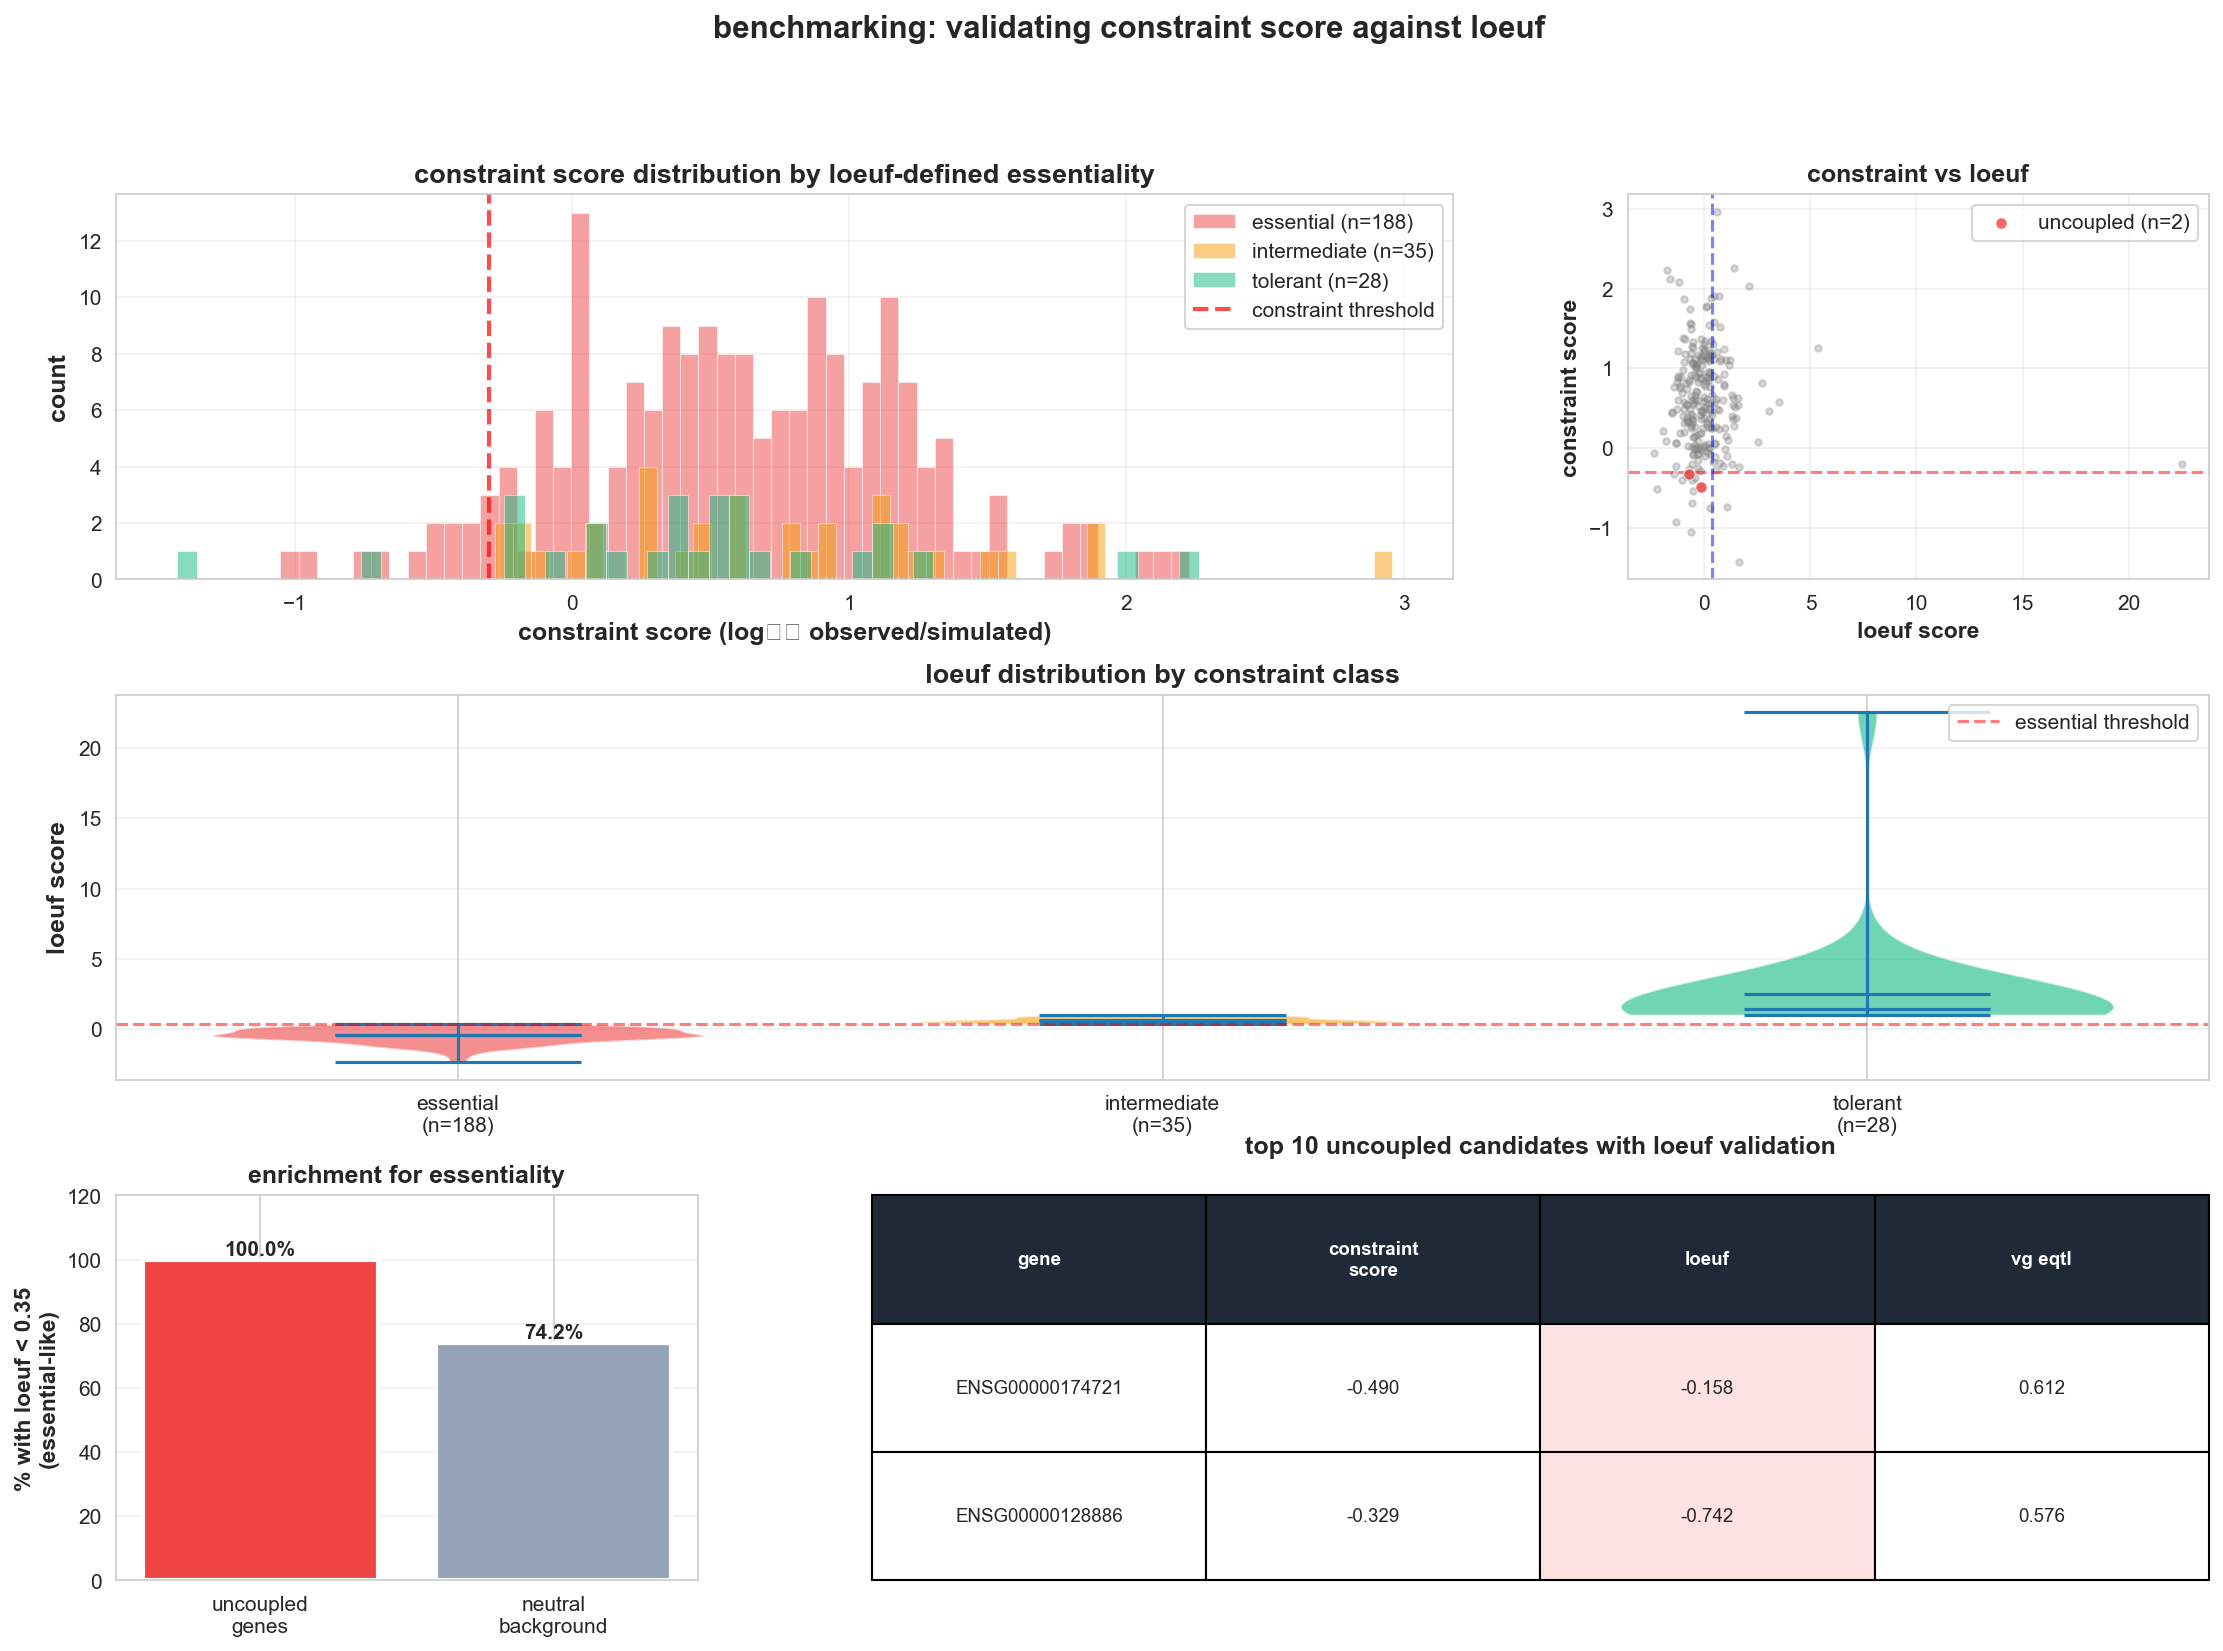

In [22]:
# visualize benchmarking results
with autosave('Standard_Benchmarking_LOEUF', verbose=True):
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # panel 1: constraint score distribution by loeuf class
    ax1 = fig.add_subplot(gs[0, :2])
    
    for group_name, color in [('essential', '#EF4444'), ('intermediate', '#F59E0B'), ('tolerant', '#10B981')]:
        group_df = loeuf_groups.get(group_name)
        if group_df is not None and len(group_df) > 0:
            scores = group_df['constraint_score'].dropna()
            ax1.hist(scores, bins=50, alpha=0.5, label=f'{group_name} (n={len(scores):,})', 
                    color=color, edgecolor='white', linewidth=0.5)
    
    ax1.axvline(-0.3, color='red', linestyle='--', linewidth=2, alpha=0.7, label='constraint threshold')
    ax1.set_xlabel('constraint score (log₁₀ observed/simulated)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('count', fontsize=12, fontweight='bold')
    ax1.set_title('constraint score distribution by loeuf-defined essentiality', 
                 fontsize=13, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # panel 2: constraint score vs loeuf scatter
    ax2 = fig.add_subplot(gs[0, 2])
    
    ax2.scatter(bg_with_loeuf['loeuf_score'], bg_with_loeuf['constraint_score'],
               alpha=0.3, s=10, color='gray')
    
    # highlight uncoupled genes
    if len(uncoupled) > 0:
        ax2.scatter(uncoupled['loeuf_score'], uncoupled['constraint_score'],
                   alpha=0.8, s=30, color='#EF4444', edgecolors='white', linewidth=0.5,
                   label=f'uncoupled (n={len(uncoupled)})', zorder=5)
    
    ax2.axhline(-0.3, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    ax2.axvline(LOEUF_ESSENTIAL, color='blue', linestyle='--', linewidth=1.5, alpha=0.5)
    
    ax2.set_xlabel('loeuf score', fontsize=11, fontweight='bold')
    ax2.set_ylabel('constraint score', fontsize=11, fontweight='bold')
    ax2.set_title('constraint vs loeuf', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # panel 3: loeuf distributions
    ax3 = fig.add_subplot(gs[1, :])
    
    violin_data = []
    violin_labels = []
    violin_colors = []
    
    for group_name, color in [('essential', '#EF4444'), ('intermediate', '#F59E0B'), ('tolerant', '#10B981')]:
        group_df = loeuf_groups.get(group_name)
        if group_df is not None and len(group_df) > 0:
            violin_data.append(group_df['loeuf_score'].dropna())
            violin_labels.append(f'{group_name}\n(n={len(group_df):,})')
            violin_colors.append(color)
    
    parts = ax3.violinplot(violin_data, positions=range(len(violin_data)), 
                           widths=0.7, showmeans=True, showmedians=True)
    
    for pc, color in zip(parts['bodies'], violin_colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.6)
    
    ax3.set_xticks(range(len(violin_labels)))
    ax3.set_xticklabels(violin_labels)
    ax3.set_ylabel('loeuf score', fontsize=12, fontweight='bold')
    ax3.set_title('loeuf distribution by constraint class', fontsize=13, fontweight='bold')
    ax3.axhline(LOEUF_ESSENTIAL, color='red', linestyle='--', alpha=0.5, label='essential threshold')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.legend()
    
    # panel 4: enrichment bar chart
    ax4 = fig.add_subplot(gs[2, 0])
    
    if len(uncoupled) > 0:
        uncoupled_essential_pct = 100 * (uncoupled['loeuf_score'] < LOEUF_ESSENTIAL).mean()
    else:
        uncoupled_essential_pct = 0
    neutral_essential_pct = 100 * (neutral['loeuf_score'] < LOEUF_ESSENTIAL).mean()
    
    bars = ax4.bar(['uncoupled\ngenes', 'neutral\nbackground'], 
                   [uncoupled_essential_pct, neutral_essential_pct],
                   color=['#EF4444', '#94A3B8'], edgecolor='white', linewidth=2)
    
    ax4.set_ylabel('% with loeuf < 0.35\n(essential-like)', fontsize=11, fontweight='bold')
    ax4.set_title('enrichment for essentiality', fontsize=12, fontweight='bold')
    ax4.set_ylim(0, max(uncoupled_essential_pct, neutral_essential_pct) * 1.2)
    
    # add value labels
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    ax4.grid(True, alpha=0.3, axis='y')
    
    # panel 5: top uncoupled genes with loeuf
    ax5 = fig.add_subplot(gs[2, 1:])
    ax5.axis('off')
    
    if len(uncoupled) > 0:
        top_uncoupled = uncoupled.nsmallest(10, 'constraint_score')[
            ['gene_id', 'constraint_score', 'loeuf_score', 'vg_eqtl']
        ].copy()
        
        table_data = [['gene', 'constraint\nscore', 'loeuf', 'vg eqtl']]
        for _, row in top_uncoupled.iterrows():
            loeuf_str = f"{row['loeuf_score']:.3f}" if pd.notna(row['loeuf_score']) else 'n/a'
            table_data.append([
                row['gene_id'][:15],
                f"{row['constraint_score']:.3f}",
                loeuf_str,
                f"{row['vg_eqtl']:.3f}"
            ])
        
        table = ax5.table(cellText=table_data, cellLoc='center', loc='center',
                         bbox=[0, 0, 1, 1])
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)
        
        # color header
        for i in range(4):
            table[(0, i)].set_facecolor('#1F2937')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        # color essential genes
        for i, (_, row) in enumerate(top_uncoupled.iterrows(), 1):
            if pd.notna(row['loeuf_score']) and row['loeuf_score'] < LOEUF_ESSENTIAL:
                table[(i, 2)].set_facecolor('#FEE2E2')
        
        ax5.set_title('top 10 uncoupled candidates with loeuf validation',
                     fontsize=12, fontweight='bold', pad=20)
    
    plt.suptitle(
        'benchmarking: validating constraint score against loeuf',
        fontsize=15, fontweight='bold', y=0.98
    )